
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [ ]:
MONTH = 21
YEAR = 252

## Load Data

In [4]:
with pd.HDFStore('stock_prices.h5') as store:
    data = store['model_data']

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

<AxesSubplot:>

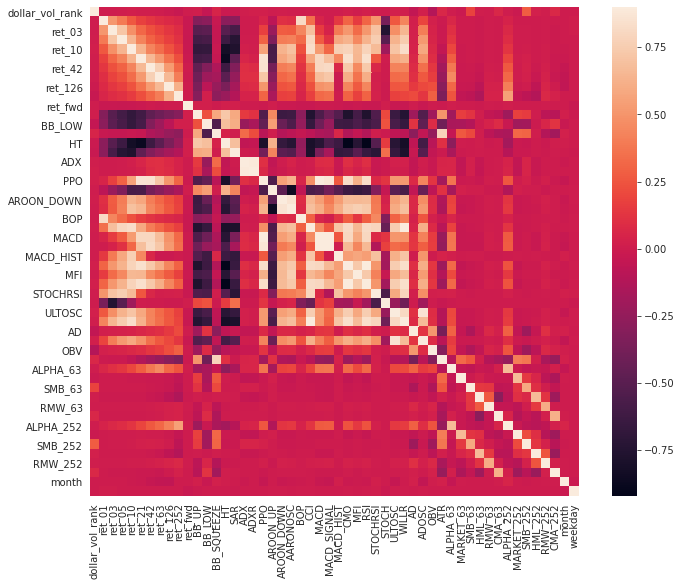

In [11]:
corrmat = data.corr('spearman')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [45]:
corr_data = {'x1':[], 'x2': [], 'rho': []}
for column in corrmat.columns:
    corr = corrmat[column].sort_values(ascending = False)
    corr_data['x1'].append(column)
    corr_data['x2'].append(corr.index[1])
    corr_data['rho'].append(corr.values[1])
    
corr_df = pd.DataFrame(corr_data)
corr_df

,x1,x2,rho
0,dollar_vol_rank,SMB_252,0.279808
1,ret_01,BOP,0.815679
2,ret_03,ret_05,0.720300
3,ret_05,CCI,0.803337
4,ret_10,WILLR,0.835620
5,ret_21,PPO,0.864102
6,ret_42,PPO,0.857273
7,ret_63,ret_42,0.771539
8,ret_126,ret_63,0.659539
9,ret_252,ret_126,0.621300


## Forward return correlation

Which features are most correlated with the forward returns?

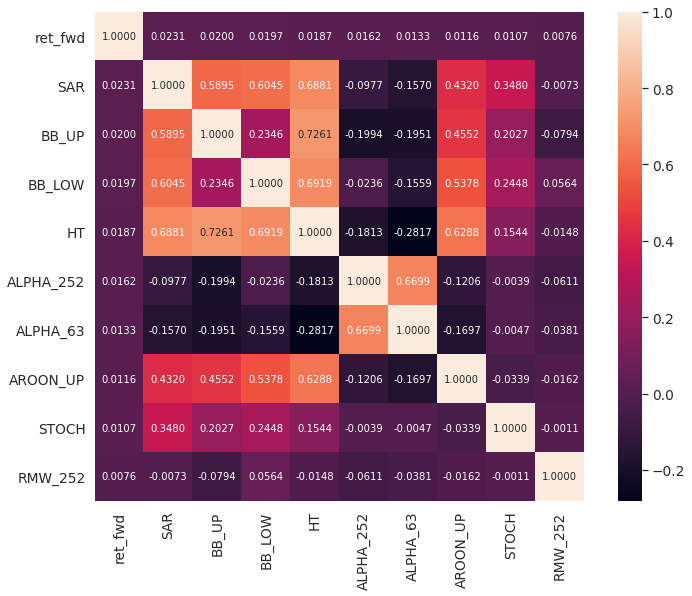

In [46]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ret_fwd')['ret_fwd'].index
cm = data.loc[:, cols].corr('spearman')
plt.subplots(figsize=(12,9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.4f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [132]:
fwd_corr = data.drop(['ret_fwd'], axis=1).corrwith(data.ret_fwd, method='spearman')

In [133]:
fwd_corr = fwd_corr.dropna()
fwd_corr.to_csv('forward_correlation.csv')

## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [5]:
from sklearn.feature_selection import mutual_info_regression

mi_data = data.dropna().sample(100000)

mi = mutual_info_regression(X = mi_data.drop('ret_fwd', axis = 1), 
                            y = mi_data['ret_fwd'],
                            discrete_features=[data.columns.get_loc('month') - 1,
                                               data.columns.get_loc('weekday') - 1]
                            )
mutual_info = pd.Series(mi, index=data.drop('ret_fwd', axis = 1).columns)
mutual_info

dollar_vol_rank    0.000375
ret_01             0.037548
ret_03             0.042322
ret_05             0.036008
ret_10             0.042191
ret_21             0.044504
ret_42             0.050783
ret_63             0.052029
ret_126            0.059501
ret_252            0.055472
BB_UP              0.059086
BB_LOW             0.025440
BB_SQUEEZE         0.078511
HT                 0.044033
SAR                0.064260
ADX                0.001191
ADXR               0.006369
PPO                0.052167
AROON_UP           0.003429
AROON_DOWN         0.007910
AARONOSC           0.008506
BOP                0.002887
CCI                0.008571
MACD               0.016068
MACD_SIGNAL        0.019174
MACD_HIST          0.007283
CMO                0.016023
MFI                0.009022
RSI                0.016024
STOCHRSI           0.003929
STOCH              0.007334
ULTOSC             0.005235
WILLR              0.011067
AD                 0.020267
ADOSC              0.002482
OBV                0

In [55]:
mutual_info = pd.Series(mi, index=data.drop('ret_fwd', axis = 1).columns)

In [131]:
mutual_info.to_csv('mutual_info.csv')

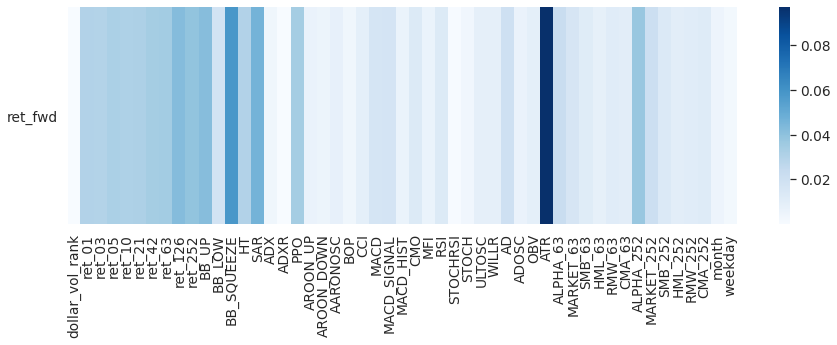

In [78]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(pd.DataFrame(mutual_info.div(mutual_info.sum())).T.rename(index={0:'ret_fwd'}), ax=ax, 
            cmap='Blues', xticklabels=True)
plt.yticks(rotation=0) 
plt.show()

In [81]:
dummy_data = pd.get_dummies(data.dropna(), columns = ['month', 'weekday'], prefix = ['month', 'weekday'],
                            prefix_sep = ['_', '_']).sample(100000)

In [82]:
dummy_features = dummy_data.dropna().drop('ret_fwd', axis=1)
cat_cols = [c for c in dummy_features.columns if c not in data.drop('ret_fwd', axis = 1).columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [84]:
mi_dummy = mutual_info_regression(X = dummy_features, 
                            y = dummy_data['ret_fwd'],
                            discrete_features=discrete_features
                            )

dollar_vol_rank    0.000124
ret_01             0.041637
ret_03             0.041479
ret_05             0.044311
ret_10             0.043237
ret_21             0.043885
ret_42             0.046806
ret_63             0.047889
ret_126            0.058020
ret_252            0.053976
BB_UP              0.057353
BB_LOW             0.025185
BB_SQUEEZE         0.079975
HT                 0.041949
SAR                0.063527
ADX                0.005454
ADXR               0.000402
PPO                0.046917
AROON_UP           0.008933
AROON_DOWN         0.007463
AARONOSC           0.011112
BOP                0.005594
CCI                0.012885
MACD               0.022940
MACD_SIGNAL        0.023661
MACD_HIST          0.008608
CMO                0.017740
MFI                0.008785
RSI                0.017739
STOCHRSI           0.000773
STOCH              0.004966
ULTOSC             0.012545
WILLR              0.012329
AD                 0.027725
ADOSC              0.008974
OBV                0

In [86]:
mi_dummy_info = pd.Series(mi_dummy, index=dummy_features.columns)
mi_dummy_info.sort_values(ascending = False)

ATR           0.133990
BB_SQUEEZE    0.081584
SAR           0.069282
ret_252       0.061241
ret_126       0.060084
                ...   
month_2       0.000047
month_6       0.000000
month_5       0.000000
weekday_1     0.000000
month_4       0.000000
Length: 66, dtype: float64

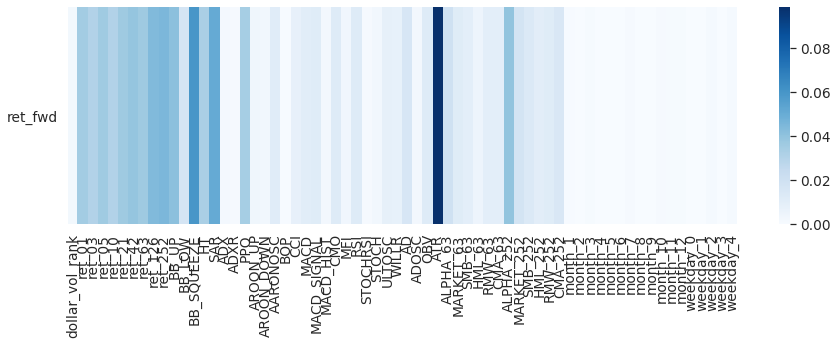

In [87]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(pd.DataFrame(mi_dummy_info.div(mi_dummy_info.sum())).T.rename(index={0:'ret_fwd'}), ax=ax, 
            cmap='Blues', xticklabels=True)
plt.yticks(rotation=0) 
plt.show()

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [89]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different model.

In [90]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [91]:
categoricals = ['month', 'weekday']

In [92]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [104]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU
#               max_bins=63,  # uncomment if using GPU
              metric=None)

In [94]:
num_boost_round = 5000

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [95]:
lgb_data = lgb.Dataset(data=data.drop('ret_fwd', axis = 1),
                       label=data['ret_fwd'],
                       categorical_feature=['month', 'weekday'],
                       free_raw_data=False)

In [96]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

### Cross-validation loop

In [105]:
for train_idx, test_idx in cv.split(X=data.drop('ret_fwd', axis = 1)):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's l2: 0.00100378	train's ic: 0.103965	valid's l2: 0.00057063	valid's ic: 0.0332508
[200]	train's l2: 0.000978536	train's ic: 0.124805	valid's l2: 0.000571052	valid's ic: 0.0331563
[300]	train's l2: 0.000962201	train's ic: 0.142526	valid's l2: 0.000571301	valid's ic: 0.034522
[400]	train's l2: 0.000949962	train's ic: 0.154262	valid's l2: 0.000571804	valid's ic: 0.0328682
[500]	train's l2: 0.000939803	train's ic: 0.163294	valid's l2: 0.00057204	valid's ic: 0.0349524
[600]	train's l2: 0.000930821	train's ic: 0.171209	valid's l2: 0.000572263	valid's ic: 0.0357382
Early stopping, best iteration is:
[145]	train's l2: 0.000991102	train's ic: 0.113922	valid's l2: 0.000570554	valid's ic: 0.0349734


We can persist the model to generate predictions later:

In [106]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [108]:
# select test features and label
test_set = data.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, 'ret_fwd']

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC:  3.50% | Average Daily IC:  2.48% | Coefficient of Variation for daily IC:   5.6 | Median Daily IC:  3.12%


While the daily average of the IC is positive at 0.028, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

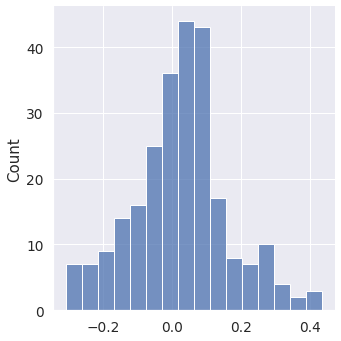

In [109]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that, while only slightly negatively skewed, but has significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [110]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean        0.0248
Std. Dev    0.1395
Median      0.0312
Skew        0.1736
Kurtosis    0.3794
dtype: object

### Compute Feature Importance

In [111]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [112]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [113]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

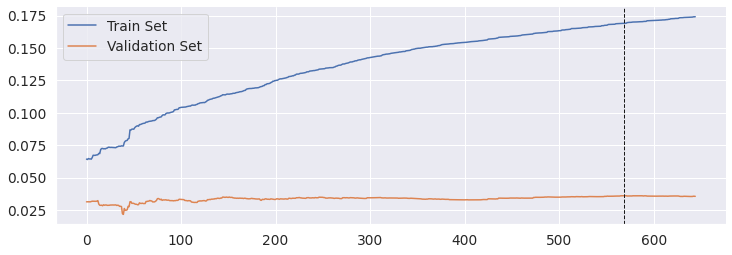

In [114]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

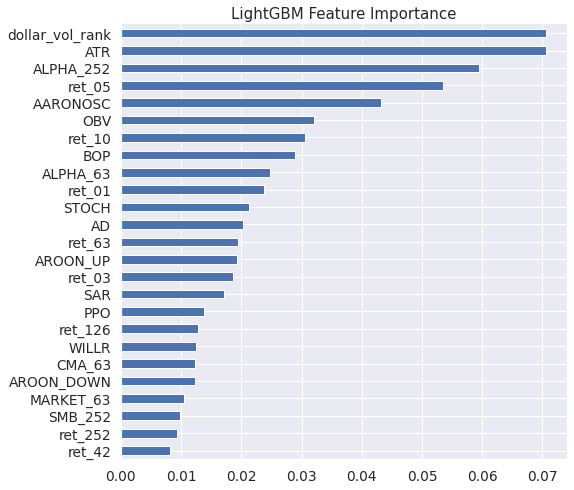

In [115]:
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [116]:
shap.initjs()

In [117]:
model = lgb.Booster(model_file='lgb_model.txt')

In [118]:
explainer = shap.TreeExplainer(model)

In [119]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [121]:
shap_values = explainer.shap_values(data.iloc[test_idx, :].loc[:, model.feature_name()])

In [122]:
np.save('shap_values.npy', shap_values)

In [123]:
shap_values = np.load('shap_values.npy')

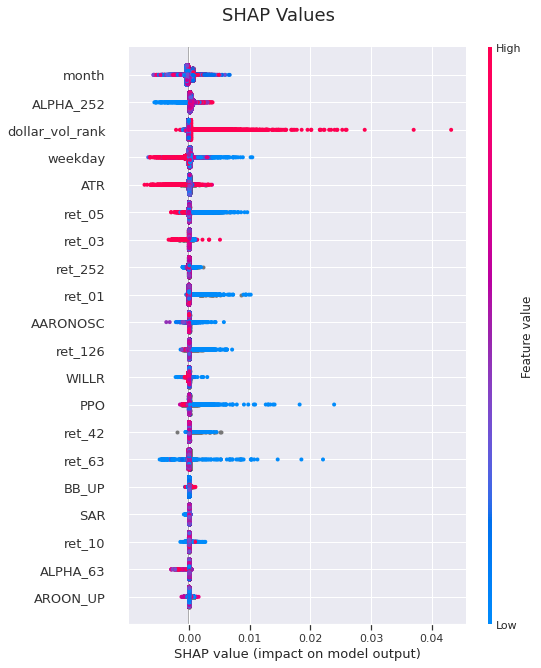

In [124]:
shap.summary_plot(shap_values,
                  data
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [126]:
shap_values = pd.DataFrame(shap_values, columns=data.drop('ret_fwd', axis = 1).columns)

In [127]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [128]:
shap_summary.nlargest(20)

month              0.216583
ALPHA_252          0.169523
dollar_vol_rank    0.131296
weekday            0.119859
ATR                0.053502
ret_05             0.033608
ret_03             0.026548
ret_252            0.025234
ret_01             0.023984
AARONOSC           0.021418
ret_126            0.020360
WILLR              0.020217
PPO                0.018735
ret_42             0.015926
ret_63             0.013378
BB_UP              0.012279
SAR                0.009350
ret_10             0.007358
ALPHA_63           0.006758
AROON_UP           0.005871
dtype: float64

In [129]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [134]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [135]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

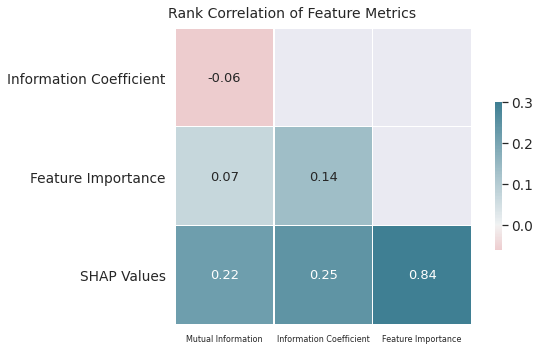

In [156]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

res = sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13},
            )

res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 8)

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

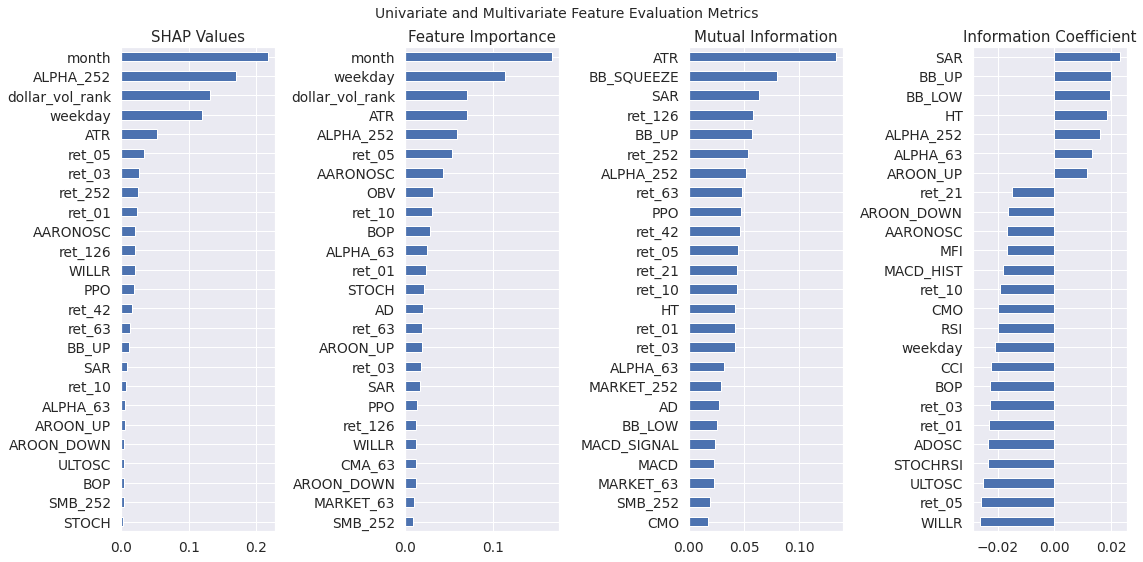

In [157]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [158]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [159]:
top_ranked.to_csv('top_features.csv')

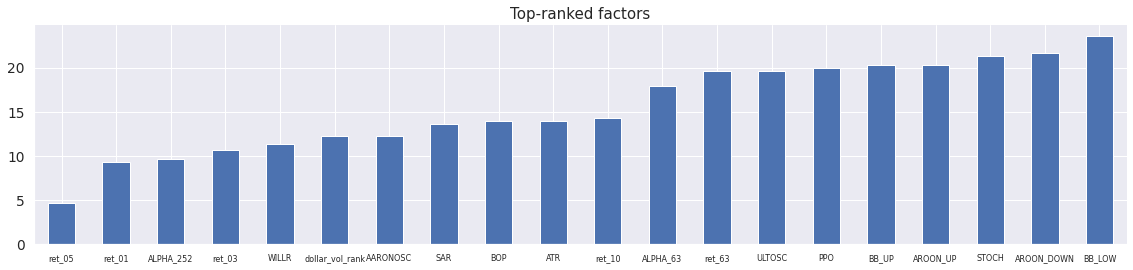

In [164]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.xticks(fontsize= 8)
plt.tight_layout();

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [6]:
tickers = data.index.unique('ticker')

### Get trade prices

We need market prices for the relevant period:

In [7]:
def get_trade_prices(tickers):
    return (pd.read_hdf('data.h5', 'data')
              .sort_index()
              .loc[idx['2006':'2017', tickers], 'open']
              .unstack('ticker')
              .shift(-1)
              .tz_localize('UTC'))

In [8]:
trade_prices = get_trade_prices(tickers)

In [11]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3049 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1398 entries, A to NMBL
dtypes: float64(1398)
memory usage: 32.5 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [9]:
alpha = 'ATR'

In [35]:
factor = (data[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [37]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

ValueError: Inferred frequency None from passed values does not conform to passed frequency C

### Create Tearsheet

In [ ]:
create_summary_tear_sheet(factor_data)